In [7]:
# ## 1. Importing Libraries
#
# We import all necessary libraries.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
import re

# ## 2. Loading the Dataset
#
# Load the dataset and inspect its shape and structure.

df = pd.read_csv("/content/laptop.csv")
print("Dataset shape:", df.shape)
print(df.head())

# ## 3. Data Cleaning and Preprocessing
# Remove missing values, clean text-based numeric columns, and drop unnecessary columns.
#
# Drop rows where Price is missing
#
df = df.dropna(subset=["Price"])
# Remove unnecessary columns
#
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Clean and convert Ram column
df["Ram"] = df["Ram"].str.replace("GB", "").astype(float)

# Clean and convert Weight column
df["Weight"] = df["Weight"].str.replace("kg", "", regex=True)
# Convert to float, replacing errors with NaN
#
df["Weight"] = pd.to_numeric(df["Weight"], errors="coerce")
# Drop rows where Weight is NaN
#
df = df.dropna(subset=["Weight"])

Dataset shape: (1303, 13)
   Unnamed: 0.1  Unnamed: 0 Company   TypeName Inches  \
0             0         0.0   Apple  Ultrabook   13.3   
1             1         1.0   Apple  Ultrabook   13.3   
2             2         2.0      HP   Notebook   15.6   
3             3         3.0   Apple  Ultrabook   15.4   
4             4         4.0   Apple  Ultrabook   13.3   

                     ScreenResolution                         Cpu   Ram  \
0  IPS Panel Retina Display 2560x1600        Intel Core i5 2.3GHz   8GB   
1                            1440x900        Intel Core i5 1.8GHz   8GB   
2                   Full HD 1920x1080  Intel Core i5 7200U 2.5GHz   8GB   
3  IPS Panel Retina Display 2880x1800        Intel Core i7 2.7GHz  16GB   
4  IPS Panel Retina Display 2560x1600        Intel Core i5 3.1GHz   8GB   

                Memory                           Gpu  OpSys  Weight  \
0            128GB SSD  Intel Iris Plus Graphics 640  macOS  1.37kg   
1  128GB Flash Storage        Intel HD

In [8]:
# ## 4. Feature Engineering
#
# Extract screen resolution features and CPU specifications.

def extract_resolution(screen):
    match = re.search(r'(\d+)x(\d+)', screen)
    if match:
        return int(match.group(1)), int(match.group(2))
    else:
        return np.nan, np.nan

df[['ResolutionWidth', 'ResolutionHeight']] = df["ScreenResolution"].apply(lambda x: pd.Series(extract_resolution(x)))
df = df.drop(columns=["ScreenResolution"])

def extract_cpu_speed(cpu):
    match = re.search(r'(\d+\.\d+)', cpu)
    if match:
        return float(match.group(1))
    else:
        return np.nan

def extract_cpu_brand(cpu):
    return cpu.split()[0] if isinstance(cpu, str) else np.nan

df["CpuSpeed"] = df["Cpu"].apply(extract_cpu_speed)
df["CpuBrand"] = df["Cpu"].apply(extract_cpu_brand)
df = df.drop(columns=["Cpu"])

print(df.head())

  Company   TypeName Inches   Ram               Memory  \
0   Apple  Ultrabook   13.3   8.0            128GB SSD   
1   Apple  Ultrabook   13.3   8.0  128GB Flash Storage   
2      HP   Notebook   15.6   8.0            256GB SSD   
3   Apple  Ultrabook   15.4  16.0            512GB SSD   
4   Apple  Ultrabook   13.3   8.0            256GB SSD   

                            Gpu  OpSys  Weight        Price  ResolutionWidth  \
0  Intel Iris Plus Graphics 640  macOS    1.37   71378.6832             2560   
1        Intel HD Graphics 6000  macOS    1.34   47895.5232             1440   
2         Intel HD Graphics 620  No OS    1.86   30636.0000             1920   
3            AMD Radeon Pro 455  macOS    1.83  135195.3360             2880   
4  Intel Iris Plus Graphics 650  macOS    1.37   96095.8080             2560   

   ResolutionHeight  CpuSpeed CpuBrand  
0              1600       2.3    Intel  
1               900       1.8    Intel  
2              1080       2.5    Intel  
3     

In [9]:
# ## 5. Handling Other Categorical Features
#
# Convert categorical variables into one-hot encoded numerical columns.

categorical_cols = ["Company", "TypeName", "OpSys", "CpuBrand"]
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
print("Columns after one-hot encoding:", df.columns.tolist())

Columns after one-hot encoding: ['Inches', 'Ram', 'Memory', 'Gpu', 'Weight', 'Price', 'ResolutionWidth', 'ResolutionHeight', 'CpuSpeed', 'Company_Apple', 'Company_Asus', 'Company_Chuwi', 'Company_Dell', 'Company_Fujitsu', 'Company_Google', 'Company_HP', 'Company_Huawei', 'Company_LG', 'Company_Lenovo', 'Company_MSI', 'Company_Mediacom', 'Company_Microsoft', 'Company_Razer', 'Company_Samsung', 'Company_Toshiba', 'Company_Vero', 'Company_Xiaomi', 'TypeName_Gaming', 'TypeName_Netbook', 'TypeName_Notebook', 'TypeName_Ultrabook', 'TypeName_Workstation', 'OpSys_Chrome OS', 'OpSys_Linux', 'OpSys_Mac OS X', 'OpSys_No OS', 'OpSys_Windows 10', 'OpSys_Windows 10 S', 'OpSys_Windows 7', 'OpSys_macOS', 'CpuBrand_Intel', 'CpuBrand_Samsung']


In [10]:
# ## 6. Defining Target and Feature Set
#
# Separate features (X) and target variable (y).

columns_to_drop = ["Memory", "Gpu"]
df_model = df.drop(columns=columns_to_drop, errors='ignore')

X = df_model.drop(columns=["Price"])
y = df_model["Price"]

print("Feature Columns:", X.columns.tolist())

Feature Columns: ['Inches', 'Ram', 'Weight', 'ResolutionWidth', 'ResolutionHeight', 'CpuSpeed', 'Company_Apple', 'Company_Asus', 'Company_Chuwi', 'Company_Dell', 'Company_Fujitsu', 'Company_Google', 'Company_HP', 'Company_Huawei', 'Company_LG', 'Company_Lenovo', 'Company_MSI', 'Company_Mediacom', 'Company_Microsoft', 'Company_Razer', 'Company_Samsung', 'Company_Toshiba', 'Company_Vero', 'Company_Xiaomi', 'TypeName_Gaming', 'TypeName_Netbook', 'TypeName_Notebook', 'TypeName_Ultrabook', 'TypeName_Workstation', 'OpSys_Chrome OS', 'OpSys_Linux', 'OpSys_Mac OS X', 'OpSys_No OS', 'OpSys_Windows 10', 'OpSys_Windows 10 S', 'OpSys_Windows 7', 'OpSys_macOS', 'CpuBrand_Intel', 'CpuBrand_Samsung']


In [11]:
# ## 7. Splitting the Data into Training and Testing Sets
#
# Use an 80-20 split for training and testing.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# ## 7.1 Cleaning Data Before Training

# Convert target variables (y_train, y_test) to Pandas Series
y_train = pd.Series(y_train).reset_index(drop=True)
y_test = pd.Series(y_test).reset_index(drop=True)

# Convert all feature columns to numeric
X_train = X_train.apply(pd.to_numeric, errors="coerce")
X_test = X_test.apply(pd.to_numeric, errors="coerce")
y_train = pd.to_numeric(y_train, errors="coerce")
y_test = pd.to_numeric(y_test, errors="coerce")

# Drop NaN values from X_train and reset index
X_train = X_train.dropna().reset_index(drop=True)
y_train = y_train[:len(X_train)]

# Drop NaN values from X_test and reset index
X_test = X_test.dropna().reset_index(drop=True)
y_test = y_test[:len(X_test)]

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (951, 39)
Testing set shape: (236, 39)


In [12]:
# ## 8. Building and Training the Model
#
# Create a pipeline with feature scaling and a Random Forest regressor.

model_pipeline = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=100, random_state=42))
model_pipeline.fit(X_train, y_train)

y_pred = model_pipeline.predict(X_test)

results = pd.DataFrame({'Actual Price': y_test, 'Predicted Price': y_pred})
print(results.head())

   Actual Price  Predicted Price
0      54931.68     37163.898456
1      71874.72     43394.737824
2      51148.80     80200.961424
3      28185.12     72026.833512
4      88977.60     56198.494584


In [13]:
# ## 9. Evaluating the Model
#
# Calculate R² score and Root Mean Squared Error (RMSE).

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("R²:", r2)
print("RMSE:", rmse)

R²: -0.32143006049591394
RMSE: 38967.91779728072


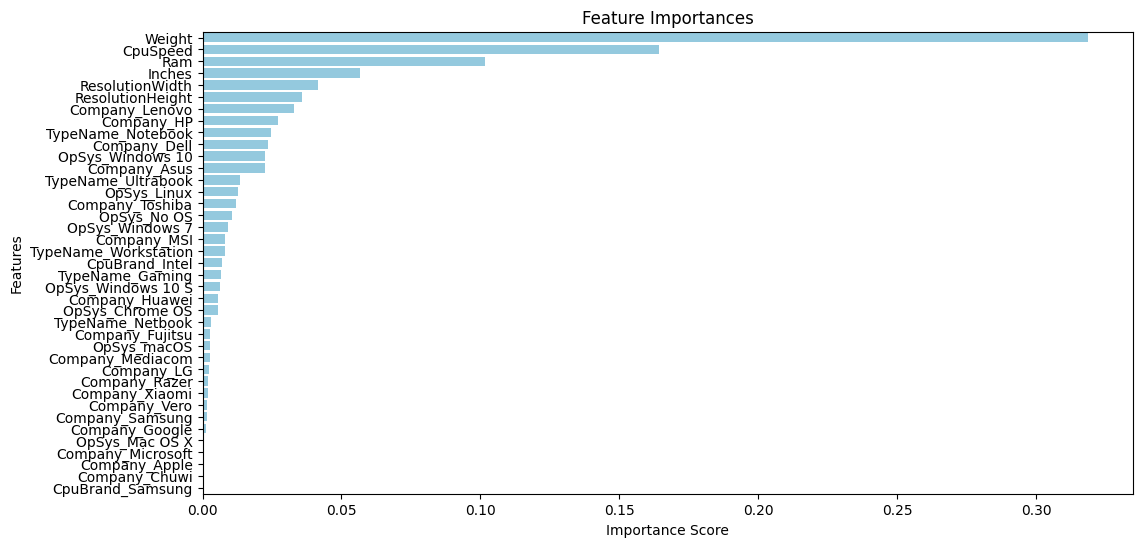

Weight                  0.318798
CpuSpeed                0.164405
Ram                     0.101521
Inches                  0.056782
ResolutionWidth         0.041487
ResolutionHeight        0.035840
Company_Lenovo          0.032857
Company_HP              0.027052
TypeName_Notebook       0.024579
Company_Dell            0.023394
OpSys_Windows 10        0.022468
Company_Asus            0.022435
TypeName_Ultrabook      0.013576
OpSys_Linux             0.012729
Company_Toshiba         0.011981
OpSys_No OS             0.010786
OpSys_Windows 7         0.009280
Company_MSI             0.008025
TypeName_Workstation    0.008014
CpuBrand_Intel          0.006930
TypeName_Gaming         0.006505
OpSys_Windows 10 S      0.006186
Company_Huawei          0.005530
OpSys_Chrome OS         0.005506
TypeName_Netbook        0.002932
Company_Fujitsu         0.002850
OpSys_macOS             0.002794
Company_Mediacom        0.002615
Company_LG              0.002272
Company_Razer           0.002097
Company_Xi

In [14]:
# ## 10. Understanding Feature Importances
#
# Extract feature importance scores and visualize them.

rf_model = model_pipeline.named_steps['randomforestregressor']
importances = rf_model.feature_importances_

feat_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=feat_importances.values, y=feat_importances.index, color='skyblue')
plt.title("Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

print(feat_importances)

In [18]:
# ## 11. Making Predictions for a New Laptop
#
# Define a function to predict prices for new laptop specifications.

def predict_laptop_price(sample_data):
    sample_df = pd.DataFrame([sample_data])

    if "Ram" in sample_df.columns:
        sample_df["Ram"] = sample_df["Ram"].astype(str).str.replace("GB", "").astype(float)
    if "Weight" in sample_df.columns:
        sample_df["Weight"] = sample_df["Weight"].astype(str).str.replace("kg", "").astype(float)

    if "ScreenResolution" in sample_df.columns:
        sample_df[['ResolutionWidth', 'ResolutionHeight']] = sample_df["ScreenResolution"].apply(lambda x: pd.Series(extract_resolution(x)))
        sample_df = sample_df.drop(columns=["ScreenResolution"])

    if "Cpu" in sample_df.columns:
        sample_df["CpuSpeed"] = sample_df["Cpu"].apply(extract_cpu_speed)
        sample_df["CpuBrand"] = sample_df["Cpu"].apply(extract_cpu_brand)
        sample_df = sample_df.drop(columns=["Cpu"])

    sample_processed = pd.get_dummies(sample_df, columns=["Company", "TypeName", "OpSys", "CpuBrand"], drop_first=True)

    sample_processed = sample_processed.reindex(columns=X.columns, fill_value=0)

    predicted_price = model_pipeline.predict(sample_processed)
    return predicted_price[0]

sample_laptop = {
    "Company": "Dell",
    "TypeName": "Notebook",
    "Inches": 15.6,
    "ScreenResolution": "Full HD 1920x1080",
    "Cpu": "Intel Core i5 2.5GHz",
    "Ram": "8GB",
    "OpSys": "Windows 10",
    "Weight": "2.18kg"
}

predicted = predict_laptop_price(sample_laptop)
print("Predicted Laptop Price: {:.2f}".format(predicted))

Predicted Laptop Price: 73612.21


In [19]:
# Save the model predictions to a CSV file for further analysis or visualization in tools like Power BI
results.to_csv("laptop_price_predictions.csv", index=False)
